# US–CN Spillover Analysis
This notebook contains only the **useful code snippets** we built:
- data + lag creation
- VAR and Granger
- Diebold–Yilmaz style spillover (GFEVD)
- rolling correlation of GARCH-standardized residuals
- ML baselines (linear, XGBoost) with **time-series CV**
- extension for richer features (momentum, vol, corr)


In [2]:
import numpy as np
import pandas as pd

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

# optional ML
import xgboost as xgb

# optional GARCH
from arch import arch_model

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

## 1. Load / prepare base data
We expect a DataFrame `data` with at least:
- `Date` (datetime)
- `US_Ret` (weekly return)
- `CN_Ret` (weekly return)

Sample rows:
        Date   US_Close   CN_Close  US_Ret  CN_Ret
0 2009-01-16 1,198.1400 1,343.7700 -0.0205  0.0667
1 2009-01-23 1,175.8900 1,362.1400 -0.0187  0.0136
2 2009-01-30 1,180.2500 1,362.1400  0.0037  0.0000
3 2009-02-06 1,277.4900 1,540.1200  0.0792  0.1228
4 2009-02-13 1,236.8500 1,697.1900 -0.0323  0.0971


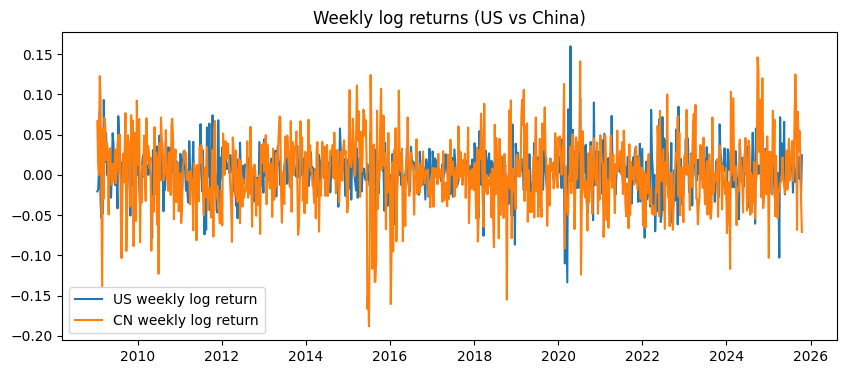

In [3]:
us = pd.read_csv('NDX_index.csv', parse_dates=['Date']).sort_values('Date')
cn = pd.read_csv('000039_index.csv', parse_dates=['Date']).sort_values('Date')

us_w = us.set_index('Date')['Close']   # keine Resample nötig
cn_w = cn.set_index('Date')['Close']

# Resample both series to weekly (Friday close). If your data is already weekly, this will simply keep it.
us_w = us.set_index('Date')['Close'].resample('W-FRI').last().ffill()
cn_w = cn.set_index('Date')['Close'].resample('W-FRI').last().ffill()


# Build DataFrame with log returns
data = pd.DataFrame({'US_Close': us_w, 'CN_Close': cn_w}).dropna()
# Log returns: simple and commonly used for VAR / GARCH
data['US_Ret'] = np.log(data['US_Close']).diff()
data['CN_Ret'] = np.log(data['CN_Close']).diff()
# drop the first NA after differencing
data = data.dropna().reset_index().rename(columns={'index': 'Date'})


print('Sample rows:')
print(data.head())


plt.figure(figsize=(10,4))
plt.plot(data['Date'], data['US_Ret'], label='US weekly log return')
plt.plot(data['Date'], data['CN_Ret'], label='CN weekly log return')
plt.legend()
plt.title('Weekly log returns (US vs China)')
plt.show()



In [4]:
assert "Date" in data.columns
assert "US_Ret" in data.columns
assert "CN_Ret" in data.columns

data = data.sort_values("Date").reset_index(drop=True)

## 2. Lag construction helper
Corrected version (the first one returned after lag 1).

In [5]:
def make_lags(df: pd.DataFrame, lags: int = 4) -> pd.DataFrame:
    """Create US/CN lag features per date.
    Expects columns: Date, US_Ret, CN_Ret
    """
    tmp = df.copy().set_index("Date")
    for i in range(1, lags + 1):
        tmp[f"CN_lag{i}"] = tmp["CN_Ret"].shift(i)
        tmp[f"US_lag{i}"] = tmp["US_Ret"].shift(i)
    tmp = tmp.dropna().reset_index()
    return tmp

lags = 4
ml_df = make_lags(data, lags=lags)
ml_df.head()

,Date,US_Close,CN_Close,US_Ret,CN_Ret,CN_lag1,US_lag1,CN_lag2,US_lag2,CN_lag3,US_lag3,CN_lag4,US_lag4
0,2009-02-13,"1,236.8500","1,697.1900",-0.0323,0.0971,0.1228,0.0792,0.0000,0.0037,0.0136,-0.0187,0.0667,-0.0205
1,2009-02-20,"1,172.7100","1,653.1900",-0.0533,-0.0263,0.0971,-0.0323,0.1228,0.0792,0.0000,0.0037,0.0136,-0.0187
2,2009-02-27,"1,116.9900","1,438.4700",-0.0487,-0.1391,-0.0263,-0.0533,0.0971,-0.0323,0.1228,0.0792,0.0000,0.0037
3,2009-03-06,"1,064.7000","1,523.5600",-0.0479,0.0575,-0.1391,-0.0487,-0.0263,-0.0533,0.0971,-0.0323,0.1228,0.0792
4,2009-03-13,"1,168.5200","1,478.9500",0.0930,-0.0297,0.0575,-0.0479,-0.1391,-0.0487,-0.0263,-0.0533,0.0971,-0.0323


## 3. VAR(1) and Granger causality (US ↔ CN)
Order selection showed lag=1 was sufficient.

In [6]:
# prepare for VAR
var_data = data[["US_Ret", "CN_Ret"]].set_index(data["Date"])  # index for convenience

# VAR(1)
model = VAR(var_data)
res = model.fit(1)
print(res.summary())

# Granger: does CN -> US?
print("\nGranger test: CN → US (H0: no causality)")
grangercausalitytests(var_data[["US_Ret", "CN_Ret"]], maxlag=4, verbose=True)

# Granger: does US -> CN?
print("\nGranger test: US → CN (H0: no causality)")
grangercausalitytests(var_data[["CN_Ret", "US_Ret"]], maxlag=4, verbose=True)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Oct, 2025
Time:                     14:59:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.5085
Nobs:                     874.000    HQIC:                  -13.5288
Log likelihood:           3443.25    FPE:                1.31547e-06
AIC:                     -13.5413    Det(Omega_mle):     1.30649e-06
--------------------------------------------------------------------
Results for equation US_Ret
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.003721         0.000928            4.009           0.000
L1.US_Ret        -0.093544         0.034617           -2.702           0.007
L1.CN_Ret         0.037528         0.021765            1.724           0.08

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(7.193315496640195),
    np.float64(0.007456108006360035),
    np.float64(871.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(7.218091554607956),
    np.float64(0.0072172400352219284),
    np.int64(1)),
   'lrtest': (np.float64(7.188448674473875),
    np.float64(0.0073374389899176495),
    np.int64(1)),
   'params_ftest': (np.float64(7.193315496640062),
    np.float64(0.0074561080063604655),
    np.float64(871.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(4.104348361578244),
    np.float64(0.01682208962030812),
    np.float64(868.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(8.25598184252951),
    np.float64(0.016115223072625383),
    np.int64(2)),
   'lrtest': (np.float64(8.217187726632801),
    np.float64(0.016430862328448936),
    np.int64(2)),
   'params_ftest': (np.float64(4.104348361578234),
    np.float64(0.01682208962030812),
    np.float64(868.0),
    2.0)},
   array([[0., 0., 1., 0., 0.]

In [7]:
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

# Momentum-Feature (12-Wochen)
data['US_Mom'] = data['US_Ret'].rolling(12).sum()
data['CN_Mom'] = data['CN_Ret'].rolling(12).sum()
var_data = data[['US_Ret', 'CN_Ret', 'US_Mom', 'CN_Mom']].dropna()

# Fit VAR
model = VAR(var_data[['US_Ret', 'CN_Ret', 'US_Mom', 'CN_Mom']])
res = model.fit(4)
print(res.summary())

# Test: US_Mom → CN_Ret
grangercausalitytests(var_data[['CN_Ret', 'US_Mom']], maxlag=4, verbose=True)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Oct, 2025
Time:                     14:59:39
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -26.9119
Nobs:                     860.000    HQIC:                  -27.1441
Log likelihood:           6920.71    FPE:                1.40915e-12
AIC:                     -27.2881    Det(Omega_mle):     1.30303e-12
--------------------------------------------------------------------
Results for equation US_Ret
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.004612         0.001078            4.280           0.000
L1.US_Ret        -0.127942         0.050130           -2.552           0.011
L1.CN_Ret         0.012412         0.031908            0.389           0.69

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(0.7152864027626518),
    np.float64(0.39792966785482486),
    np.float64(860.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.717781587888568),
    np.float64(0.39687255399146226),
    np.int64(1)),
   'lrtest': (np.float64(0.7174832536420581),
    np.float64(0.39697069042120436),
    np.int64(1)),
   'params_ftest': (np.float64(0.715286402762777),
    np.float64(0.39792966785479345),
    np.float64(860.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.9783002017090963),
    np.float64(0.1389352200157326),
    np.float64(857.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(3.979684419774191),
    np.float64(0.13671699633393014),
    np.int64(2)),
   'lrtest': (np.float64(3.9705258876929292),
    np.float64(0.13734449547864364),
    np.int64(2)),
   'params_ftest': (np.float64(1.9783002017094198),
    np.float64(0.1389352200156762),
    np.float64(857.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
   

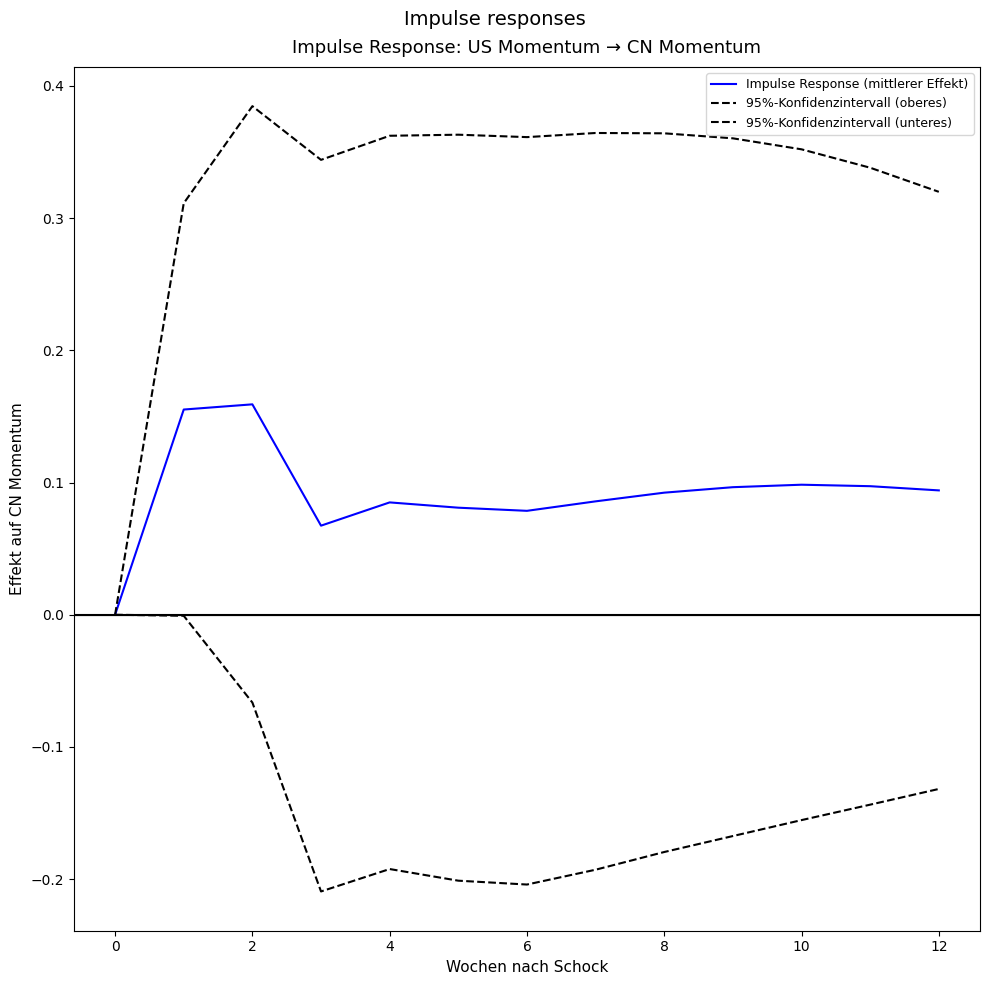

In [10]:
import matplotlib.pyplot as plt

irf = res.irf(12)
fig = irf.plot(orth=False, impulse='US_Mom', response='CN_Mom')

ax = fig.axes[0]
ax.set_title("Impulse Response: US Momentum → CN Momentum", fontsize=13, pad=10)
ax.set_xlabel("Wochen nach Schock", fontsize=11)
ax.set_ylabel("Effekt auf CN Momentum", fontsize=11)
ax.axhline(0, color='black', linewidth=0.8)  # Nulllinie
ax.legend([
    "Impulse Response (mittlerer Effekt)",
    "95%-Konfidenzintervall (oberes)",
    "95%-Konfidenzintervall (unteres)"
], loc="upper right", fontsize=9)

plt.tight_layout()
plt.show()



## 4. Diebold–Yilmaz-style GFEVD spillover (2 variables)
This matches the code you ran, but wrapped once.

In [8]:
def gfevd_spillover(res, h: int = 10, labels=("US", "CN")):
    """Compute generalized FEVD matrix and total spillover index for a fitted VAR.
    res ... statsmodels VARResults
    h  ... forecast horizon
    """
    Psi = np.asarray(res.ma_rep(maxn=h - 1))   # (h, k, k)
    Sigma = np.asarray(res.sigma_u)            # (k, k)
    k = Psi.shape[1]
    sigma_diag = np.diag(Sigma).astype(float)

    num = np.zeros((k, k), dtype=float)
    den = np.zeros(k, dtype=float)

    for s in range(h):
        Ps = Psi[s]               # (k, k)
        B = Ps @ Sigma            # (k, k)
        num += (B * B) / sigma_diag[np.newaxis, :]
        den += np.sum(B * Ps, axis=1)

    GFEVD = num / den.reshape(-1, 1)
    GFEVD = GFEVD / GFEVD.sum(axis=1, keepdims=True)

    off_diag = GFEVD.sum() - np.trace(GFEVD)
    total_spill = off_diag / k

    idx = [f"{l}_recipient" for l in labels[:k]]
    cols = [f"{l}_source" for l in labels[:k]]
    df = pd.DataFrame(GFEVD, index=idx, columns=cols)
    return total_spill, df

total_spill, spill_df = gfevd_spillover(res, h=10, labels=("US", "CN"))
print(f"Total spillover index (h=10): {total_spill:.4f}")
print("\nFEVD share matrix (rows=recipient, cols=source):")
print(spill_df.round(4))

ValueError: Shape of passed values is (4, 4), indices imply (2, 2)

## 5. Rolling correlation of GARCH-standardized residuals
This shows time-varying co-movement of shocks.

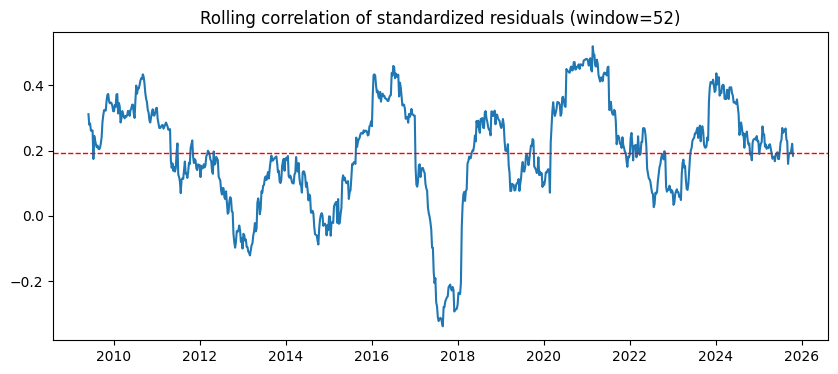

Average rolling correlation: 0.1937


In [ ]:
# fit univariate GARCH(1,1) for both (scale by 100)
us_garch = arch_model(data["US_Ret"] * 100, p=1, q=1).fit(disp="off")
cn_garch = arch_model(data["CN_Ret"] * 100, p=1, q=1).fit(disp="off")

us_std = us_garch.resid / us_garch.conditional_volatility
cn_std = cn_garch.resid / cn_garch.conditional_volatility

std = pd.concat([
    data["Date"],
    us_std.rename("US_std"),
    cn_std.rename("CN_std")
], axis=1).dropna()

roll_corr = std["US_std"].rolling(window=52, min_periods=20).corr(std["CN_std"])

plt.figure(figsize=(10, 4))
plt.plot(std["Date"], roll_corr)
plt.title("Rolling correlation of standardized residuals (window=52)")
plt.axhline(roll_corr.mean(), color="red", linestyle="--", linewidth=1)
plt.show()

print(f"Average rolling correlation: {roll_corr.mean():.4f}")

## 6. Time-series ML: linear baseline, XGBoost
We predict **CN_Ret** from its own lags **plus** US lags (the version that worked best).

In [ ]:
lags = 4
ml_df = make_lags(data, lags=lags)

cn_feats = [f"CN_lag{i}" for i in range(1, lags + 1)]
us_feats = [f"US_lag{i}" for i in range(1, lags + 1)]
features = cn_feats + us_feats

X = ml_df[features].values
y = ml_df["CN_Ret"].values

print("ML sample size:", X.shape)
print("Features:", features)

tscv = TimeSeriesSplit(n_splits=5)

# 6.1 linear baseline
preds_lin = np.zeros_like(y, dtype=float)
for train_idx, test_idx in tscv.split(X):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[train_idx])
    X_test = scaler.transform(X[test_idx])

    lr = LinearRegression()
    lr.fit(X_train, y[train_idx])
    preds_lin[test_idx] = lr.predict(X_test)

print("Lin RMSE:", np.sqrt(mean_squared_error(y, preds_lin)))
print("Lin R2:", r2_score(y, preds_lin))

# 6.2 XGBoost with same splits
preds_xgb = np.zeros_like(y, dtype=float)
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=100,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds_xgb[test_idx] = model.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y, preds_xgb)))
print("XGBoost R2:", r2_score(y, preds_xgb))

ML sample size: (871, 8)
Features: ['CN_lag1', 'CN_lag2', 'CN_lag3', 'CN_lag4', 'US_lag1', 'US_lag2', 'US_lag3', 'US_lag4']
Lin RMSE: 0.043941406003797256
Lin R2: -0.027573955738995348
XGBoost RMSE: 0.047831797021151694
XGBoost R2: -0.21758302631487858


## 7. NN template with time-series CV
Note: with weekly returns this will likely **not** beat the linear model — kept here as template.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

preds_nn = np.zeros_like(y, dtype=float)

for train_idx, test_idx in TimeSeriesSplit(n_splits=5).split(X):
    # scale per fold to avoid lookahead
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[train_idx])
    X_test = scaler.transform(X[test_idx])
    y_train = y[train_idx]
    y_test = y[test_idx]

    nn = Sequential([
        Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    nn.compile(optimizer="adam", loss="mse")
    es = EarlyStopping(patience=5, restore_best_weights=True, verbose=0)

    nn.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=60,
        verbose=0,
        callbacks=[es]
    )

    preds_nn[test_idx] = nn.predict(X_test, verbose=0).flatten()

print("NN RMSE:", np.sqrt(mean_squared_error(y, preds_nn)))
print("NN R2:", r2_score(y, preds_nn))

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_reg

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN RMSE: 0.0707594338922217
NN R2: -1.6646114496932092


## 8. Enriching features: momentum, volatility, rolling corr
To improve predictability, add state variables.

In [ ]:
df = data.copy()
df["US_mom_12"] = df["US_Ret"].rolling(12).sum()
df["CN_mom_12"] = df["CN_Ret"].rolling(12).sum()
df["US_vol_12"] = df["US_Ret"].rolling(12).std()
df["CN_vol_12"] = df["CN_Ret"].rolling(12).std()
df["rollcorr_12"] = df["US_Ret"].rolling(12).corr(df["CN_Ret"])
df = df.dropna().reset_index(drop=True)

ml_df2 = make_lags(df, lags=4)
lag_feats = [c for c in ml_df2.columns if "lag" in c]
extra_feats = ["US_mom_12", "CN_mom_12", "US_vol_12", "CN_vol_12", "rollcorr_12"]
features2 = lag_feats + extra_feats

X2 = ml_df2[features2].values
y2 = ml_df2["CN_Ret"].values

tscv = TimeSeriesSplit(n_splits=5)
preds_xgb2 = np.zeros_like(y2, dtype=float)
for train_idx, test_idx in tscv.split(X2):
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=150, random_state=42)
    model.fit(X2[train_idx], y2[train_idx])
    preds_xgb2[test_idx] = model.predict(X2[test_idx])

print("XGB (enriched) RMSE:", np.sqrt(mean_squared_error(y2, preds_xgb2)))
print("XGB (enriched) R2:", r2_score(y2, preds_xgb2))

XGB (enriched) RMSE: 0.04485113928887815
XGB (enriched) R2: -0.0882469886397712
